# visualization

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
#from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os
from loss_functions.triplet_loss import TripletLoss
import math
import glob
from os import listdir
from os import walk
import PIL.Image as Image
from matplotlib import pyplot as plt
from tqdm import tqdm 

BATCH_SIZE = 32
WORKERS = 8
DATA_PATH_TEST = '../../dataset/face_labeled_data/test'

model_path_facenet = "./model_facenet/checkpoint_0100.pth.tar"
model_path_simsiam = "./model_facenet_simsiam/checkpoint_0100.pth.tar"

## check gpu

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Available GPUs: ', end='')
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i), end=' ')
else:
    device = torch.device('cpu')
    print('CUDA is not available.')

Available GPUs: GeForce RTX 2080 Ti GeForce GTX 1080 Ti 

## defind transforms

In [3]:
trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

## define dataset, dataloader

In [4]:
dataset_test = datasets.ImageFolder(DATA_PATH_TEST, transform=trans)
test_loader = DataLoader(
    dataset_test,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=False
)

## define model from file

In [5]:
def loadModel(path):
    model = InceptionResnetV1().to(device)
    model.load_state_dict(torch.load(path)['state_dict'])
    model.eval()
    return model

## computing features (y,  y_pre)

In [6]:
def computing_features(model, loader):
    result_pre_list = []
    result_target_list = []
    print('data size', dataset_test.__len__())
    print('index size', len(dataset_test.class_to_idx))
    for i_batch, image_batch in tqdm(enumerate(loader)):
            x, y = image_batch[0].to(device), image_batch[1].to(device)
            y_pred = model(x)
            for pre in enumerate(y_pred.cpu().detach().numpy()):
                result_pre_list.append(pre[1])
            for target in enumerate(y.cpu().detach().numpy()):
                result_target_list.append(target[1])
    return result_pre_list, result_target_list

## Draw distribution map

In [7]:
def draw_cluster(ax, pca_data, target, sampling_index):
    times = [0 for i in range(len(dataset_test.class_to_idx))]
    for i in range(len(pca_data)):
        if int(target[i]) < sampling_index[0] or int(target[i]) >= sampling_index[1]: 
            continue
        if times[int(target[i])] == 0:
            ax.scatter(pca_data[i,0],pca_data[i,1], color = plt.cm.Set1(int(target[i])), label=target[i])
            times[int(target[i])]+=1
        else:
            ax.scatter(pca_data[i,0],pca_data[i,1], color = plt.cm.Set1(int(target[i])))

## 置信橢圓

In [8]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(pos, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    x = [x[0] for x in pos]
    y = [x[1] for x in pos]

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

## PCA

In [9]:
from sklearn.decomposition import PCA
def feature2pca(y_pre):
    pca = PCA(n_components=2)
    return pca.fit_transform(y_pre)

## t-sne

In [10]:
from sklearn import manifold
def featurn2tsne(y_pre):
    return manifold.TSNE(n_components=2, init='random', random_state=5, verbose=0).fit_transform(y_pre)

## var

In [11]:
def get_var_list(y_pre, target):
    varlist = []
    for index in np.unique(target):
        data = y_pre[[x for x, y in list(enumerate(target))if y == index]]
        varlist.append(np.var(data))
    return varlist

## Draw ellipse

In [12]:
def draw_ellipse(ax, y_pre, target, sampling_index):
    for index in np.unique(target):
        if index < sampling_index[0] or index >= sampling_index[1]:
            continue
        data = y_pre[[x for x, y in list(enumerate(target))if y == index]]
        confidence_ellipse(np.array(data),ax, edgecolor='red')

## 計算結果

In [13]:
# facenet
model_facenet = loadModel(model_path_facenet)
y_pre_facenet, target_facenet = computing_features(model_facenet, test_loader)
y_pre_pca_facenet = feature2pca(y_pre_facenet)
y_pre_tsne_facenet = featurn2tsne(y_pre_facenet)
#var_list_facenet = get_var_list(y_pre_facenet, target_facenet)
var_list_pca_facenet = get_var_list(y_pre_pca_facenet, target_facenet)
var_list_tsne_facenet = get_var_list(y_pre_tsne_facenet, target_facenet)

# simsiam
model_simsiam = loadModel(model_path_simsiam)
y_pre_simsiam, target_simsiam = computing_features(model_simsiam, test_loader)
y_pre_pca_simsiam = feature2pca(y_pre_simsiam)
y_pre_tsne_simsiam = featurn2tsne(y_pre_simsiam)
#var_list_simsiam = get_var_list(y_pre_simsiam, target_simsiam)
var_list_pca_simsiam = get_var_list(y_pre_pca_simsiam, target_simsiam)
var_list_tsne_simsiam = get_var_list(y_pre_tsne_simsiam, target_simsiam)

data size 2388
index size 186


75it [00:04, 15.39it/s]


data size 2388
index size 186


75it [00:04, 17.74it/s]


## Result

facenet pca mean 0.1481681626010725
facenet tsne mean 205.28107
simsiam pca mean 0.12091805984003665
simsiam tsne mean 236.14738


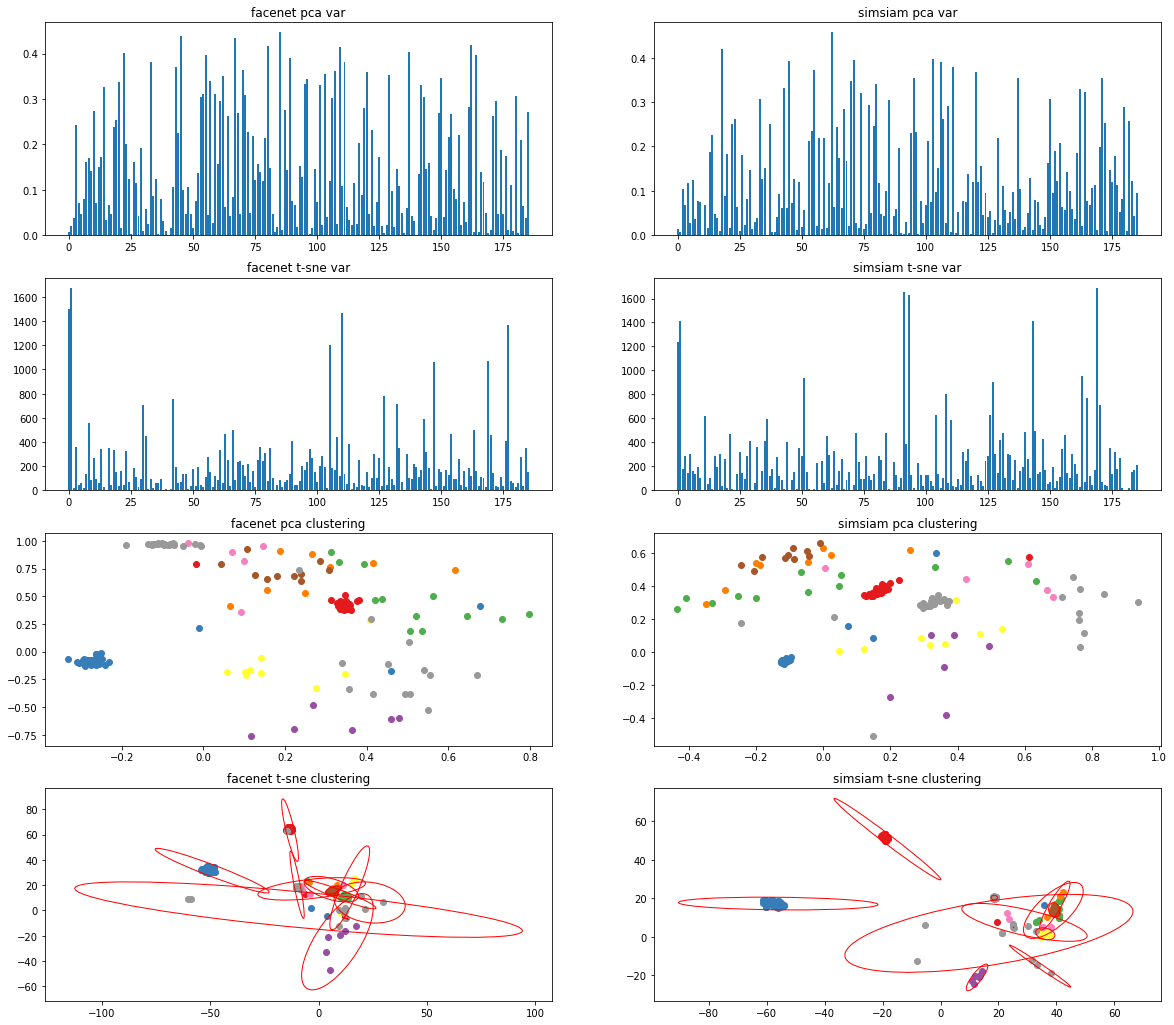

In [14]:
sampling_index = [0, 12]
fig, axs = plt.subplots(4, 2, figsize=(20, 18))
# facenet
axs[0,0].title.set_text('facenet pca var')
axs[1,0].title.set_text('facenet t-sne var')
axs[2,0].title.set_text('facenet pca clustering')
axs[3,0].title.set_text('facenet t-sne clustering')

axs[0,0].bar(np.unique(target_facenet), var_list_pca_facenet)
axs[1,0].bar(np.unique(target_facenet), var_list_tsne_facenet)

print('facenet pca mean', np.mean(var_list_pca_facenet))
print('facenet tsne mean', np.mean(var_list_tsne_facenet))
draw_cluster(axs[2,0], y_pre_pca_facenet, target_facenet, sampling_index)
draw_cluster(axs[3,0], y_pre_tsne_facenet, target_facenet, sampling_index)
draw_ellipse(axs[3,0], y_pre_tsne_facenet, target_facenet, sampling_index)

# simsiam
axs[0,1].title.set_text('simsiam pca var')
axs[1,1].title.set_text('simsiam t-sne var')
axs[2,1].title.set_text('simsiam pca clustering')
axs[3,1].title.set_text('simsiam t-sne clustering')

axs[0,1].bar(np.unique(target_simsiam), var_list_pca_simsiam)
axs[1,1].bar(np.unique(target_simsiam), var_list_tsne_simsiam)

print('simsiam pca mean', np.mean(var_list_pca_simsiam))
print('simsiam tsne mean', np.mean(var_list_tsne_simsiam))

draw_cluster(axs[2,1], y_pre_pca_simsiam, target_simsiam, sampling_index)
draw_cluster(axs[3,1], y_pre_tsne_simsiam, target_simsiam, sampling_index)
draw_ellipse(axs[3,1], y_pre_tsne_simsiam, target_simsiam, sampling_index)
plt.savefig('visualization.png')